In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [2]:
!kaggle competitions download -c llm-classification-finetuning
!unzip llm-classification-finetuning.zip


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open llm-classification-finetuning.zip, llm-classification-finetuning.zip.zip or llm-classification-finetuning.zip.ZIP.


In [3]:
BASE_PATH = "/kaggle/input/llm-classification-finetuning"  # Adjust based on your environment
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')



In [4]:
import pandas as pd

# Display first few rows
print(train_df.head())

# Check dataset info
print(train_df.info())

# Check for missing values
print(train_df.isnull().sum())


       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   
3  ["Creating a test set for a very rare category...   
4  ["The best way to travel from Tel Aviv to Jeru...   

 

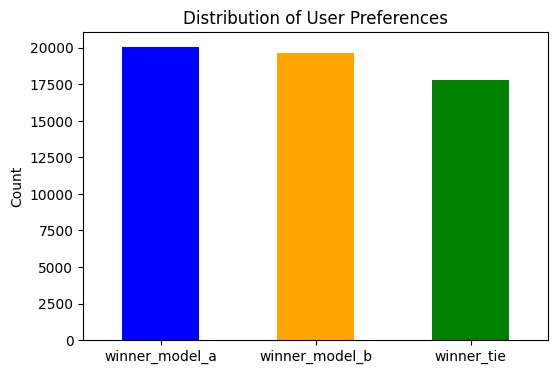

In [5]:
import matplotlib.pyplot as plt

# Count occurrences of each target class
winner_counts = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].sum()

# Plot the distribution
plt.figure(figsize=(6, 4))
winner_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribution of User Preferences')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


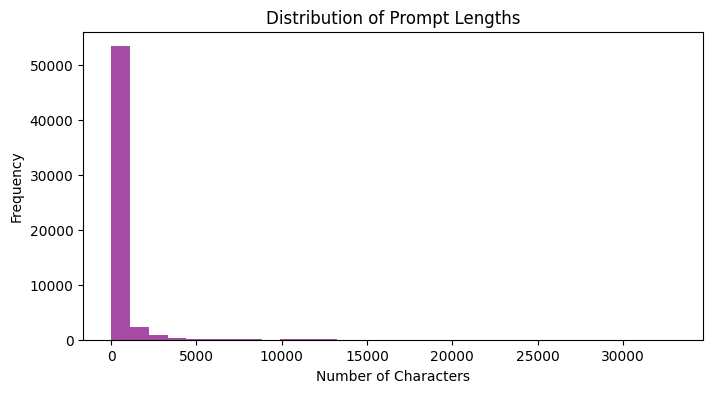

In [6]:
train_df['prompt_length'] = train_df['prompt'].apply(len)

plt.figure(figsize=(8, 4))
plt.hist(train_df['prompt_length'], bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Prompt Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()


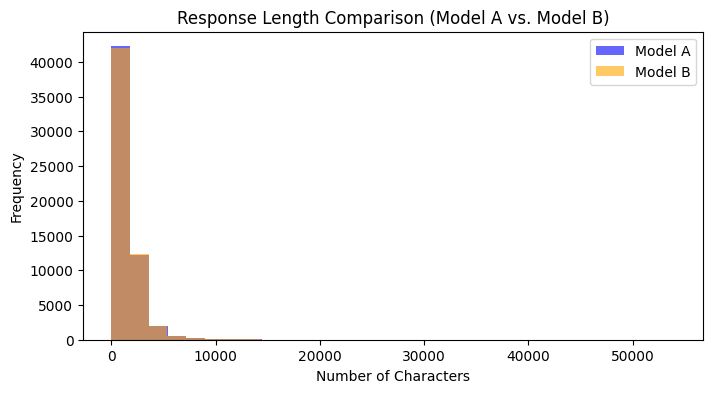

In [7]:
train_df['response_a_length'] = train_df['response_a'].apply(len)
train_df['response_b_length'] = train_df['response_b'].apply(len)

plt.figure(figsize=(8, 4))
plt.hist(train_df['response_a_length'], bins=30, alpha=0.6, label='Model A', color='blue')
plt.hist(train_df['response_b_length'], bins=30, alpha=0.6, label='Model B', color='orange')
plt.title('Response Length Comparison (Model A vs. Model B)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [8]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenize and count words
all_words = ' '.join(train_df['prompt']).lower().translate(str.maketrans('', '', string.punctuation)).split()
filtered_words = [word for word in all_words if word not in stop_words]
word_counts = Counter(filtered_words)

# Show top 10 words
print(word_counts.most_common(10))


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[('n', 11902), ('write', 7576), ('one', 6553), ('like', 6141), ('would', 5850), ('use', 5183), ('make', 4984), ('1', 4822), ('please', 4459), ('2', 4291)]


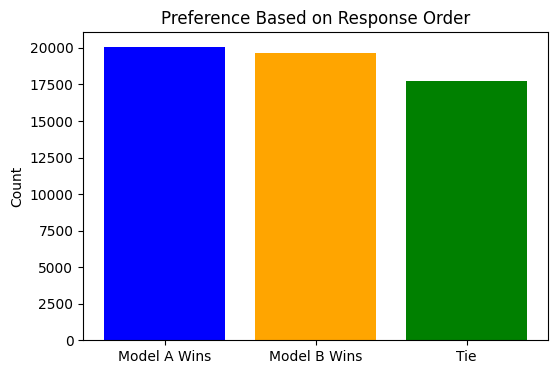

In [9]:
a_wins = train_df['winner_model_a'].sum()
b_wins = train_df['winner_model_b'].sum()
ties = train_df['winner_tie'].sum()

plt.figure(figsize=(6, 4))
plt.bar(['Model A Wins', 'Model B Wins', 'Tie'], [a_wins, b_wins, ties], color=['blue', 'orange', 'green'])
plt.title('Preference Based on Response Order')
plt.ylabel('Count')
plt.show()


In [10]:
train_df['prompt_length'] = train_df['prompt'].apply(len)
train_df['response_a_length'] = train_df['response_a'].apply(len)
train_df['response_b_length'] = train_df['response_b'].apply(len)
train_df['length_diff'] = abs(train_df['response_a_length'] - train_df['response_b_length'])


In [11]:
def flesch_reading_ease(text):
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('?') + text.count('!')
    num_syllables = sum([sum([char in 'aeiouy' for char in word]) for word in words]) + 1

    # Avoid division by zero
    if num_sentences == 0:
        num_sentences = 1

    # Flesch Reading Ease Formula
    score = 206.835 - (1.015 * num_words / num_sentences) - (84.6 * (num_syllables / num_words))
    return score

# Apply to dataset
train_df['response_a_readability'] = train_df['response_a'].apply(flesch_reading_ease)
train_df['response_b_readability'] = train_df['response_b'].apply(flesch_reading_ease)
train_df['readability_diff'] = abs(train_df['response_a_readability'] - train_df['response_b_readability'])

# Show sample
train_df[['response_a_readability', 'response_b_readability', 'readability_diff']].head()


,response_a_readability,response_b_readability,readability_diff
0,-3.038125,27.844706,30.882831
1,6.225733,8.349632,2.123899
2,30.041232,31.982619,1.941387
3,13.666418,21.734209,8.067791
4,29.738696,20.075922,9.662774


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from xgboost import XGBClassifier


In [13]:
# Select useful features
features = ['prompt_length', 'response_a_length', 'response_b_length', 'length_diff', 'readability_diff']

# Features (X) and Target (y)
X = train_df[features]
y = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']]  # Multi-class target

# Train-validation split (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [14]:
# Convert multi-label target to a single categorical column
train_df['winner'] = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1)

# Map categorical labels to numeric values (XGBoost requires this)
label_mapping = {'winner_model_a': 0, 'winner_model_b': 1, 'winner_tie': 2}
train_df['winner'] = train_df['winner'].map(label_mapping)

# Define features and target
X = train_df[features]
y = train_df['winner']  # Now a single-column integer target

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [15]:
# Define XGBoost model
xgb_model = XGBClassifier(
    objective="multi:softprob",  # Multi-class classification
    eval_metric="mlogloss",
    num_class=3,  # 3 categories: Model A wins, Model B wins, or Tie
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Predict probabilities
y_pred_xgb = xgb_model.predict_proba(X_val_scaled)

# Evaluate Log Loss
xgb_loss = log_loss(y_val, y_pred_xgb)
print(f"📊 XGBoost Log Loss: {xgb_loss:.4f}")


📊 XGBoost Log Loss: 1.0556


In [16]:
# Ensure test dataset has the same features as train dataset
test_df['prompt_length'] = test_df['prompt'].apply(len)
test_df['response_a_length'] = test_df['response_a'].apply(len)
test_df['response_b_length'] = test_df['response_b'].apply(len)
test_df['length_diff'] = abs(test_df['response_a_length'] - test_df['response_b_length'])

# If readability feature is used, recalculate it (use the same function as before)
def flesch_reading_ease(text):
    words = text.split()
    num_words = len(words)
    num_sentences = text.count('.') + text.count('?') + text.count('!')
    num_syllables = sum([sum([char in 'aeiouy' for char in word]) for word in words]) + 1

    if num_sentences == 0:
        num_sentences = 1

    score = 206.835 - (1.015 * num_words / num_sentences) - (84.6 * (num_syllables / num_words))
    return score

test_df['response_a_readability'] = test_df['response_a'].apply(flesch_reading_ease)
test_df['response_b_readability'] = test_df['response_b'].apply(flesch_reading_ease)
test_df['readability_diff'] = abs(test_df['response_a_readability'] - test_df['response_b_readability'])

# Verify that test_df now has the required columns
print(test_df[features].head())


   prompt_length  response_a_length  response_b_length  length_diff  \
0             86                 31                114           83   
1            488               1457                460          997   
2            217               3984               3716          268   

   readability_diff  
0         11.461974  
1         27.430785  
2         28.607267  


In [17]:
%time test_df[features].describe()


CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.9 ms


,prompt_length,response_a_length,response_b_length,length_diff,readability_diff
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,263.666667,1824.000000,1430.000000,449.333333,22.500008
std,205.022763,2001.891356,1987.278541,483.229069,9.577300
min,86.000000,31.000000,114.000000,83.000000,11.461974
25%,151.500000,744.000000,287.000000,175.500000,19.446379
50%,217.000000,1457.000000,460.000000,268.000000,27.430785
75%,352.500000,2720.500000,2088.000000,632.500000,28.019026
max,488.000000,3984.000000,3716.000000,997.000000,28.607267


In [18]:
test_X = scaler.transform(test_df[features].astype(np.float32))


In [19]:
%time test_X = scaler.transform(test_df[features])


CPU times: user 1.87 ms, sys: 0 ns, total: 1.87 ms
Wall time: 1.81 ms


In [20]:
test_predictions = xgb_model.predict_proba(test_X)


In [21]:
submission = pd.DataFrame(test_predictions, columns=['winner_model_a', 'winner_model_b', 'winner_tie'])
submission.insert(0, 'id', test_df['id'])
submission.to_csv("submission.csv", index=False)

print("✅ Submission file saved successfully! 🎉")


✅ Submission file saved successfully! 🎉


In [22]:
# Predict probabilities using trained XGBoost model
test_predictions = xgb_model.predict_proba(test_X)


In [23]:
import joblib

# Save the trained model
joblib.dump(xgb_model, "xgboost_model.pkl")

print("✅ Model saved as 'xgboost_model.pkl'!")

✅ Model saved as 'xgboost_model.pkl'!


In [24]:
xgb_model.save_model("xgboost_model.json")
print("✅ Model saved as 'xgboost_model.json'!")

✅ Model saved as 'xgboost_model.json'!


In [25]:
import joblib

# Load the saved model
xgb_model = joblib.load("xgboost_model.pkl")

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [26]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.load_model("xgboost_model.json")

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [27]:
import joblib

# Save the trained model
joblib.dump(xgb_model, "/kaggle/working/xgboost_model.pkl")

print("✅ Model saved at /kaggle/working/xgboost_model.pkl")


✅ Model saved at /kaggle/working/xgboost_model.pkl


In [28]:
import joblib

# Load the saved model
xgb_model = joblib.load("/kaggle/working/xgboost_model.pkl")

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [29]:
import joblib

# Save model in Kaggle's working directory
joblib.dump(xgb_model, "/kaggle/working/xgboost_model.pkl")


['/kaggle/working/xgboost_model.pkl']